<a href="https://colab.research.google.com/github/yinon2592/-Python-Beyond-The-Basics---OOP/blob/master/Transformer_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
# drive.mount('/content/drive/my-drive/project_calculations')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import math
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Download historical ticker_symbol stock price data with a broader date range

ticker_symbol = 'AAPL'

df = yf.download(ticker_symbol, period='max')

# Get the first date in the DataFrame
first_date = df.index[0].date()

# Print the first date
print(f"The first ever date of collected data for {ticker_symbol} is:", first_date)


# get ticker_symbol data from last 5 years
end_date = "2023-08-01"
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=5)
period_in_years = round(((pd.to_datetime(end_date) - start_date).days / 365.25) + 0.5) # round the period in years
print("Period in years (rounded):", period_in_years)

# Filter the DataFrame based on the date range
df = df[(df.index >= start_date) & (df.index <= end_date)]

# remain features that are needed OHLCV
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# MAP DATE TO DAYS FROM FIRST DATE
df['Date'] = df.index
df['Date'] = df['Date'].map(lambda x: (x.date() - first_date).days)
# sort the dataframe by dates

# df = df[['Open', 'High', 'Low', 'Close', 'Volume']] # ********************************************#

# df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']] # ********************************************#

df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

df = df.sort_index(axis=0)


# df = df[['Open', 'High', 'Low', 'Close', 'Volume']] # ****** change to OHLCV ******* to remove ??
# df = df[['Close']]  # ****** change to C ******* to remove ??

# get Close index
close_index = df.columns.get_loc('Close')

# divide the data to train validation and test
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
test_size = len(df) - train_size - val_size

# print(train_size, val_size, test_size)
print("train size:", train_size)
print("validation size:", val_size)
print("test size:", test_size)

df_train = df.iloc[:train_size]
# # use rollingwindow on df_train
# df_train['Clsoe'] = df_train['Clsoe'].rolling(window=10).mean().dropna()

df_val = df.iloc[train_size:train_size + val_size]
df_test = df.iloc[train_size + val_size:]

# Scale the data
scaler = MinMaxScaler((0, 1))
scaled_df_train = scaler.fit_transform(df_train)
scaled_df_val = scaler.transform(df_val)
scaled_df_test = scaler.transform(df_test)

[*********************100%%**********************]  1 of 1 completed
The first ever date of collected data for AAPL is: 1980-12-12
Period in years (rounded): 5
train size: 1006
validation size: 125
test size: 127


In [4]:
def prepare_data(scaled_df, days_before_pred, pred_days):
    x = []
    y = []
    for i in range(days_before_pred, len(scaled_df) - pred_days):
        x.append(scaled_df[i - days_before_pred:i])
        # y is just the next 7 days close price
        y.append(scaled_df[i:i + pred_days, close_index])
    x = np.array(x)
    # x = x.reshape(x.shape[0],1, -1)
    y = np.array(y)
    y = y.reshape(y.shape[0], 1, -1)
    return x, y

In [5]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, days_before_pred):
        super(Transformer, self).__init__()
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=1600), num_layers=1)
        self.linear = nn.Linear(input_dim,input_dim)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3 , padding=0, stride=1)
        self.decoder_1 = nn.Linear((input_dim - 2) * (days_before_pred - 2), 5 * output_dim)
        self.decoder_2 = nn.Linear(5 * output_dim, output_dim)

    def forward(self, src):
        encoder_output = self.encoder(src)
        linear_output = self.relu(self.linear(encoder_output))
        conv_output = self.conv(linear_output.view(encoder_output.shape[0], 1, linear_output.shape[1], encoder_output.shape[2]))
        decoder_1_output = self.decoder_1(conv_output.view(conv_output.shape[0], 1, -1))
        output = self.decoder_2(decoder_1_output)
        return output

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# load model from drive
folder_path = f'/content/drive/MyDrive/projectB/{ticker_symbol}_transformer/'
model = Transformer(input_dim=len(df.columns), output_dim=7, days_before_pred=70)
model.load_state_dict(torch.load(folder_path + f'{ticker_symbol}_transformer_model.pth', map_location=torch.device('cpu')))
model.to(device)


# load train_losses, val_losses, test_losses from drive
train_losses = np.load(folder_path + 'train_losses.npy')
val_losses = np.load(folder_path + 'val_losses.npy')
test_losses = np.load(folder_path + 'test_losses.npy')

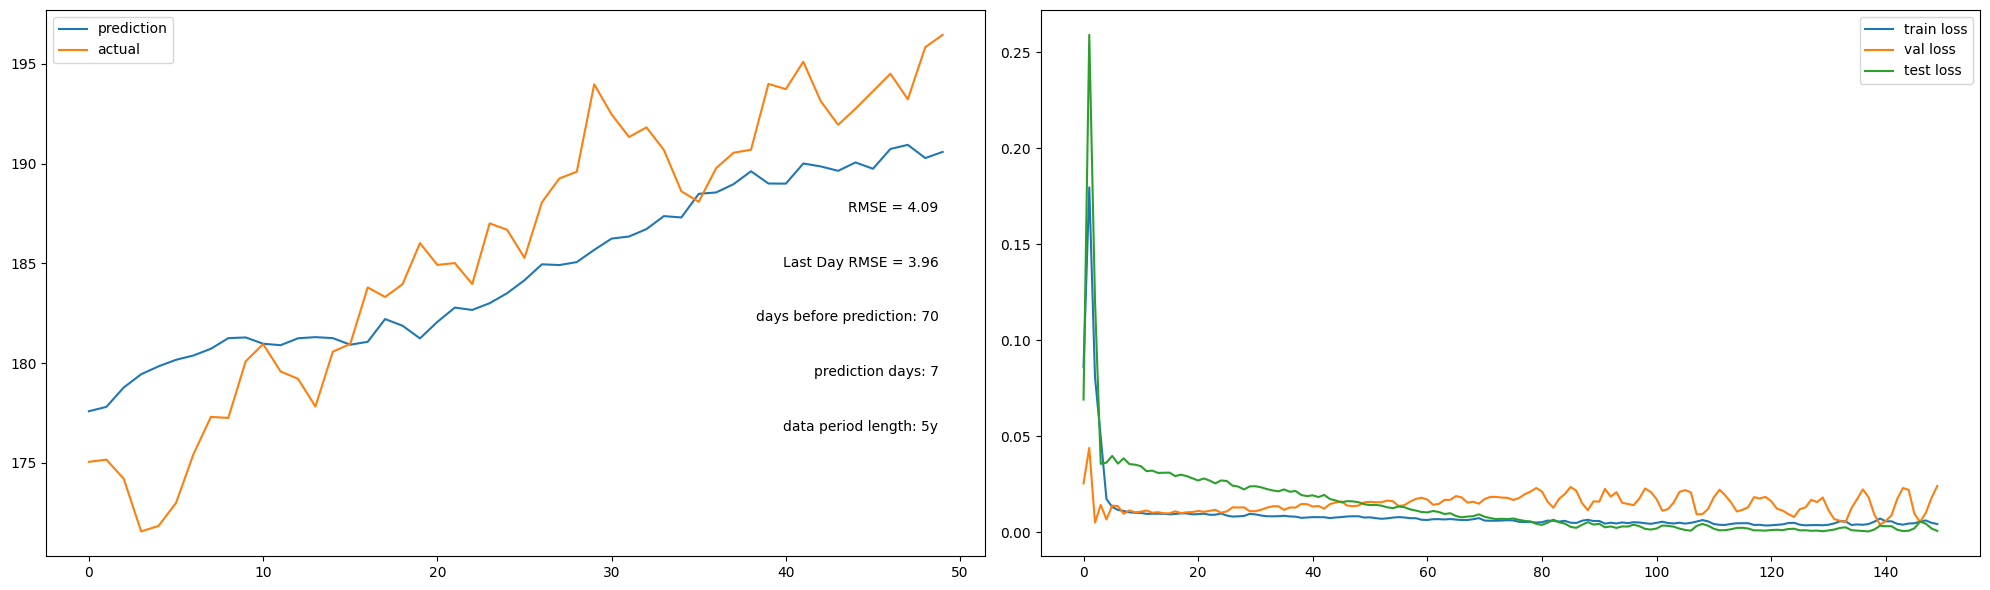

In [12]:
pred_days=7
days_before_pred=70
# get scaler on close price
test_scaler = MinMaxScaler(feature_range=(0, 1))
test_scaler.fit(np.array(df_train)[:, close_index].reshape(-1, 1))

x_test, y_test = prepare_data(scaled_df_test, days_before_pred=days_before_pred, pred_days=pred_days)

test_input_data = torch.from_numpy(x_test).float()
test_target_data = torch.from_numpy(y_test).float()

# Create DataLoader for test dataset
test_dataset = TensorDataset(test_input_data, test_target_data)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model.eval()

with torch.no_grad():
    y_pred = model(test_input_data).cpu().numpy()
    # print("model(test_input_data).cpu().numpy() = ", y_pred)
    y_pred = test_scaler.inverse_transform(y_pred .reshape(-1, 1))
    # print("scaler.inverse_transform(y_pred .reshape(-1, 1)) = ", y_pred)
    y_pred = y_pred.reshape(test_input_data.shape[0], 1, pred_days)
    # print("y_pred.reshape(test_input_data.shape[0], 1, pred_days) = ", y_pred)
    y_test = test_scaler.inverse_transform(test_target_data.numpy().reshape(-1, 1))
    y_test = y_test.reshape(test_target_data.shape[0], 1, pred_days)
    rmse = np.sqrt(np.mean(np.square(y_pred - y_test)))
    # calculate last day of prediction rmse score
    last_day_rmse = np.sqrt(np.mean(np.square(y_pred[:, 0, -1] - y_test[:, 0, -1])))
    # print("RMSE:", rmse)
    # print(y_test)
    # print(y_pred)

# Define the figure and axes for the subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plot the first graph (RMSE comparison)
axes[0].text(0.95, 0.65, 'RMSE = {:.2f}'.format(rmse), horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.55, 'Last Day RMSE = {:.2f}'.format(last_day_rmse), horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.45, 'days before prediction: {}'.format(days_before_pred), horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.35, 'prediction days: {}'.format(pred_days), horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.25, 'data period length: {}y'.format(period_in_years), horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].plot(y_pred[:, 0, -1], label='prediction')
axes[0].plot(y_test[:, 0, -1], label='actual')
axes[0].legend()

# Plot the second graph (losses)
axes[1].plot(train_losses, label='train loss')
axes[1].plot(val_losses, label='val loss')
axes[1].plot(test_losses, label='test loss')
axes[1].legend()

# Set a tight layout to prevent overlap
plt.tight_layout()

# Show the subplots
plt.show()

In [11]:
profit = 0
for i in range(1, len(y_pred)):
    if y_pred[i, 0, -1] > y_pred[i, 0, 0]:
        profit += y_test[i, 0, -1] - y_test[i, 0, 0]
print("profit:", profit)

profit: 121.71994018554688
